## Linear Classification

`Objectives:`
- Linear Classification
- Loss Functions
 - Multi-class SVM Loss function (hinge loss)
 - Multi-class Logistic Regression loss function (cross-entopy or softmax)
- Optimization
- Gradient Descent Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import classification_function_folder.layers
from classification_function_folder.data_utils import load_CIFAR10
 
plt.rcParams['figure.figsize'] = (12.0 , 6.0)   #set default size of plots
plt.rcParams['image.interpolation'] = 'spline16'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
np.set_printoptions(formatter={'all': lambda x: '%.2f' %x})

#### CIFAR-10 Data Loading and Preprocessing

In [3]:
from classification_function_folder.data_utils import load_CIFAR10
cifar10_dir = './datasets/cifar-10-batches-py'
x_train , y_train , x_test , y_test = load_CIFAR10(cifar10_dir)

print("training data shape:      " , x_train.shape)
print("training labels shape:    " , y_train.shape)
print("test data shape:          " , x_test.shape)
print("test labels shape:        " , y_test.shape)

training data shape:       (50000, 32, 32, 3)
training labels shape:     (50000,)
test data shape:           (10000, 32, 32, 3)
test labels shape:         (10000,)


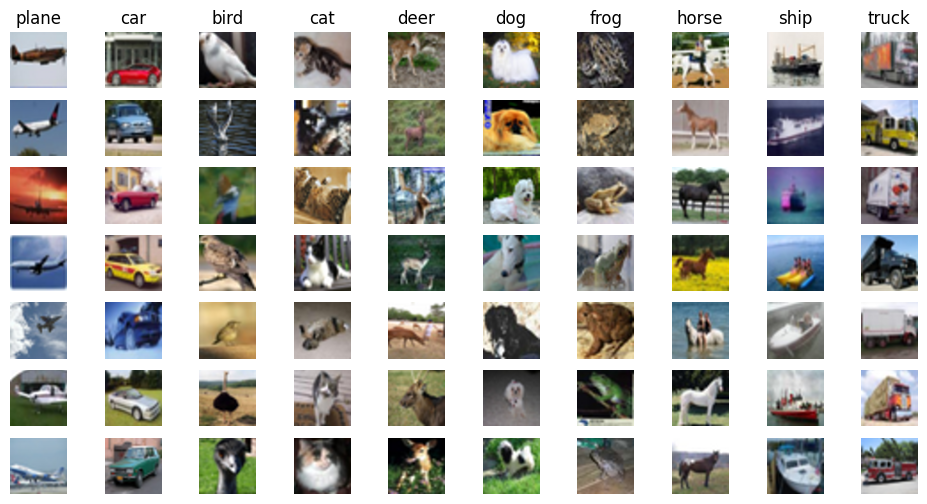

In [4]:
#visualize some examples from the dataset.
#we show a few example of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.

mask = range(num_training , num_training + num_validation)
x_val = x_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.

mask = range(num_training)
x_train = x_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.

mask = np.random.choice(num_training , num_dev , replace=False)
x_dev = x_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.

mask = range(num_test)
x_test = x_test[mask]
y_test = y_test[mask]

print('train data shape       :' , x_train.shape)
print('train labels shape     :' , y_train.shape)
print('validation data shape  :' , x_val.shape)
print('validation labels shape  :' , x_val.shape)
print('test data shape        :' , x_test.shape)
print('test labels shape        :' , y_test.shape)

train data shape       : (49000, 32, 32, 3)
train labels shape     : (49000,)
validation data shape  : (1000, 32, 32, 3)
validation labels shape  : (1000, 32, 32, 3)
test data shape        : (1000, 32, 32, 3)
test labels shape        : (1000,)


In [6]:
#preprocessing: reshape the image data into rows.
x_train = np.reshape(x_train , (x_train.shape[0] , -1))
x_val = np.reshape(x_val , (x_val.shape[0] , -1))
x_test = np.reshape(x_test , (x_test.shape[0] , -1))
x_dev = np.reshape(x_dev , (x_dev.shape[0] , -1))

# As a sanity check, print out the shapes of the data
print('Training data shape:   ', x_train.shape)
print('Validation data shape: ', x_val.shape)
print('Test data shape:       ', x_test.shape)
print('dev data shape:        ', x_dev.shape)

Training data shape:    (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:        (1000, 3072)
dev data shape:         (500, 3072)


[130.64 135.98 132.47 130.06 135.35 131.75 130.96 136.14 132.48 131.48]


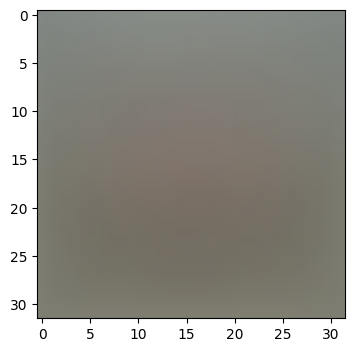

In [7]:
#preprocessing: subtract the mean image
#first: copute the image mean based on the training data
mean_image = np.mean(x_train , axis=0)
print(mean_image[:10]) #print few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape(32,32,3).astype('uint8'))  #visualize the mean image
plt.show() 

In [8]:
#second: subtract the mean image from train and test data
x_train -= mean_image
x_test -= mean_image
x_val -= mean_image
x_dev -= mean_image

### parametric classification
+ in any parametric method, there is a fixed set of parameters.
+ the goal of learning is to determine the best possible values for these parameters.
+ after learning parameters from data, we can predict for new using only these parameters.

### linear classification

#### defining a linear layer: forward step

In [9]:
def affine_forward(x , W , b):
    '''
    linear maping from inputs to scores.
    input:
    x input matrix
    w weight matrix
    b bias matrix
    
    output:
    output of linear layet(n , c)
    '''
    x2d = np.reshape(x, (x.shape[0] , -1)) # convert 4D input matrix to 2D
    out = np.dot(x2d,W) + b
    cache = (x , W , b)
    return out , cache

### `multi class svm loss function`


##### unvectorized implementation

In [10]:
def L_i(x,y,W):
    #unvectorized version, compute the multiclass svm loss a single example (x,y)
    scores = W.dot(x) #scores becomes of size 10 * 1, the scores for each class
    correct_class_score = scores[y]
    C = W.shape[0]

    loss_i = 0.0
    for j in range(C):
        if j==y:
            #skip for the true class to only loop over incorrect classes
            continue
        # accumulatea loss for the i-th example
        loss_i += max(0,scores[j - correct_class_score + 1.0])
    return loss_i

##### half vectorized implementation

In [11]:
def L_i_vectorized(x , y , W):
    #faster way
    scores = W.dot(x)
    margins = np.maximum(0 , scores - scores[y] + 1.0)
    margins[y] = 0
    loss_i = np.sum(margins)
    return loss_i

##### fully vectorized implementation

In [ ]:
def svm_loss(scores, y, W, reg=1e-3):
    # Fully-vectorized implementation of SVM loss function.

    N = scores.shape[0]  
    # Compute svm data loss
    correct_class_scores = scores[range(N), y]
    margins = np.maximum(0.0, scores - correct_class_scores[:, None] + 1.0)
    margins[range(N), y] = 0.0
    loss = np.sum(margins) / N

    # Adding L2-regularization loss
    loss += 0.5 * reg * np.sum(W * W)

    # Compute gradient off loss function w.r.t. scores
    # We will write this part later
    grads = {} 

    return loss, grads

In [14]:
#creat W and b randomly with small numbers
N = x_train.shape[0]    #number of training data
D = np.prod(x_train.shape[1:])  #number of features
C = 10  #number of classes

# init parameters
W = 0.001 * np.random.randn(D , C)
b = np.zeros((C , ))